# MS&E 234 Project

### Data cleaning

In [52]:
import pandas as pd
import numpy as np
import re
from random import sample
import os
import itertools
from collections import defaultdict,Counter
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib import ticker

### Step 1: Load data

In [ ]:
df_raw = pd.DataFrame()
path = os.getcwd()
for i in range(1, 4+1):
    df_raw = pd.concat([df_raw, pd.read_csv(f'{path}/netflix-prize-kaggle-data/combined_data_{i}.txt',
        header=None,
        names=['CustomerID', 'Rating', 'Date'])])
df_raw = df_raw.reset_index(drop = True)
df_raw

### Step 2: Generate Training & Testing Datasets

In [ ]:
def generate_dataset(df, users, train):
    df = df[df['CustomerID'].isin(users)]
    print(f"Subset of 10000 users: {df.shape[0]} ratings; {df['CustomerID'].nunique()} users")

    if (train == True):
        # assume 50% of the transactions are public
        idxs = df[['CustomerID']].reset_index().groupby('CustomerID').agg({'index':lambda x: list(x)}).to_numpy().tolist()
        drop_idxs = []
        for i in range(len(idxs)):
            drop_idxs.append(sample(idxs[i][0], len(idxs[i][0]) // 2))
        drop_idxs = list(itertools.chain(*drop_idxs))
        df = df.drop(drop_idxs)
        print(f'After making 50% private: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')
    
        # only consider users with at least 100 public transactions
        df = df[df['CustomerID'].isin(df['CustomerID'].value_counts()[df['CustomerID'].value_counts() >= 100].index)]
        print(f'Filter for users with >= 100 public transactions: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')

    # Subset the data to analyze only ratings from July 2005
    df = df[df['Date'].apply(lambda x: type(x) == str and bool(re.match(r'2005-07.*', x)))]
    print(f'Only July 2005: {df.shape[0]} ratings; {df["CustomerID"].nunique()} users')

    return df

In [ ]:
# extract movie ID's from raw data, combine these with df
# The data files follow the following format:
# Movie ID:
# CustomerID, Rating, Date
# ...
def add_movie_info(df, movie_df):
    # get movie id boundaries
    movie_rows = np.array(movie_df.index)

    # create a column with movie ids to add to df
    movie_ids = []
    curr_idx = 0
    for row in df.itertuples(index = True, name = 'Pandas'):
        curr_row = row.Index
        while curr_idx < len(movie_rows) - 1:
            next_movie_row = movie_rows[curr_idx + 1]
            if curr_row > next_movie_row:
                curr_idx += 1
            else:
                break
        movie_ids.append(curr_idx + 1) # since index of movie IDs starts at 1
    
    # add movie ids and days
    df['MovieID'] = movie_ids
    df['Day'] = pd.DatetimeIndex(df['Date']).day

    return df

In [ ]:
# get movie ids
movie_df = df_raw[df_raw['Rating'].isnull()]

In [ ]:
# generate a random sample of users
users = sample(df_raw.dropna()['CustomerID'].unique().tolist(), 10000)
train = generate_dataset(df_raw, users, train=True)
train = add_movie_info(train, movie_df)

# get test data with users that have over 100 public transactions
valid_users = set(train['CustomerID'].unique())
test = generate_dataset(df_raw, users, train=False)
test = test[test['CustomerID'].isin(valid_users)]
test = add_movie_info(test, movie_df)

In [ ]:
# testing to see double the number of transactions but the same users
print(len(train))
print(len(test))
print(train['CustomerID'].nunique())
print(test['CustomerID'].nunique())

In [ ]:
# save files for easy loading
train.to_csv(path + '/train.csv')
test.to_csv(path + '/test.csv')

### Step 3: Generate Related Movies' Lists

In [ ]:
# input: 2 sets x, y
# output: for binary vectors x and y: cosine similarity = |x and y| / sqrt(|x||y|)
def getCosSim(x, y):
    return len(x.intersection(y)) / np.sqrt(len(x) * len(y))

In [ ]:
# input: sparse binary adjList
# output: dict of the 50 most similar items and scores, in format: dict[movieID] => ([(items, scores)])
def getSimListDaily(adjList):
    simList = {}
    for key1 in adjList.keys():
        cosSims = []
        for key2 in adjList.keys():
            if key1 == key2:
                continue
            cosSim = getCosSim(adjList[key1], adjList[key2])
            cosSims.append((key2, cosSim))
        simList[key1] = sorted(cosSims, key = lambda x: (-x[1], x[0]))[:50]
    return simList

In [ ]:
# input: dataframe of customerIDs, Ratings, Day of Month, and MovieIDs
# input dataframe should contain both public and private data, as the recc system uses all available information
# output: list of 50 related movies and similarity ratings per day
# on each consecutive day, more data is used by the recc system
# uses cosine similarity on a binary matrix
def getSimListMonthly(df):
    adjList = defaultdict(set)
    
    simLists = []
    
    for day in sorted(df["Day"].unique()):
        # add new movies from today to adjList
        currDF = df[df["Day"] == day]
        for row in currDF.itertuples(index = True, name = 'Pandas'):
            adjList[row.MovieID].add(row.CustomerID)
        
        # compute similarity scores
        currSimList = getSimListDaily(adjList)
        simLists.append(currSimList)
    return simLists

In [ ]:
sim_list = getSimListMonthly(test)

In [ ]:
# shows the top 5 movies related to movie id (second value) on the last day of July 2005
sim_list[30][30][0:5]

In [ ]:

# save sim_list for easy usage
sim_list_file = path + '/sim_list.pkl'
with open(sim_list_file, 'wb') as f:
    pickle.dump(sim_list, f)

## Part 3: Inference Algorithm

In [2]:
# read in files
path = os.getcwd()
train = pd.read_csv(path + '/train.csv', index_col=0)
test = pd.read_csv(path + '/test.csv', index_col=0)

sim_list_file = path + '/sim_list.pkl'
sim_list = None
with open(sim_list_file, 'rb') as f:
    sim_list = pickle.load(f)

In [3]:
print(f'Train set: {len(train)} transactions')
print(f'Test set: {len(test)} transactions')

Train set: 35224 transactions
Test set: 70004 transactions


In [4]:

# group data into transactions -> (user, day)
transaction_counts = test.groupby(['CustomerID', 'Day']).count()
print(f'Number of transactions: {len(transaction_counts)}')

# remove (customer, date) pairs with more than 5 transactions
transaction_counts = transaction_counts[transaction_counts['Rating']  <= 5]
print(f'Number of (customer, date) with <= 5 occurrences: {len(transaction_counts)}')
transaction_counts = transaction_counts.reset_index()

# reset the indices
train = train.reset_index()
test = test.reset_index()


Number of transactions: 9040
Number of (customer, date) with <= 5 occurrences: 7336


In [67]:
inferences = {}
accuracy = {}
yields = {}
observation_period = 1
threshold = 0.75
users = train['CustomerID'].unique()

In [68]:
for user_idx, user in enumerate(users): 
    # get transactions such that user has no more than 5 per day
    valid_days = transaction_counts[transaction_counts['CustomerID'] == user]['Day'].values
    
    # check to see if user has valid days
    if len(valid_days) == 0:
        continue

    # get valid, public data for those days
    valid_transactions = train[(train['CustomerID'] == user) & (train['Day'].isin(valid_days))]
    train_idxs = list(valid_transactions.index)
    
    # get auxillary information
    aux = set()
    aux_idxs = list(valid_transactions['MovieID'].unique())
    num_aux = len(aux_idxs)

    # setup data matrix
    delta_matrix = {}
    target_items = list(test['MovieID'].unique())
    for target_item in target_items:
        delta_matrix[target_item] = [()] * num_aux

    # setup inference, yeild and accuracy dictionaries
    user_inferences = {}
    user_yields = {}
    user_accuracies = {}

    # generate inferences for each day
    for day in range(1, 32, observation_period):
        user_inferences[day] = []

        # check to see if there are aux movies to add
        if day in valid_days:
            new_movies = list(valid_transactions[valid_transactions['Day'] == day]['MovieID'])
            aux.update(new_movies)

        # update the delta matrix (target item: [] -> position for each aux item on day)
        for movie in aux:
            # get related items for each movie
            movie_sim_list = sim_list[day-1][movie]
            similar_movies = [similar_movie[0] for similar_movie in movie_sim_list]

            # get index for accessing delta matrix items
            aux_idx = aux_idxs.index(movie)
            
            # iterate through the related items and update the position in each array
            for item in target_items:
                curr_pos = 0
                prev_pos = 0

                # scenario 1: the item is similar to the aux item and has previously been seen before today
                if item in similar_movies and len(delta_matrix[item][aux_idx]) != 0:
                    prev_pos = delta_matrix[item][aux_idx][0]
                    curr_pos = similar_movies.index(item) + 1
                    delta_matrix[item][aux_idx] = (curr_pos, prev_pos-curr_pos)
                # scenario 2: the item is similar to the aux item but has not been seen before today
                elif item in similar_movies and len(delta_matrix[item][aux_idx]) == 0:
                    curr_pos = similar_movies.index(item)
                    delta_matrix[item][aux_idx] = (curr_pos + 1, curr_pos + 1)
                # scenario 3: item is not similar to the aux item
                else: 
                    delta_matrix[item][aux_idx] = ()

        # generate scores for each target item
        for target in delta_matrix:
            scores = [delta for delta in delta_matrix[target] if len(delta) != 0]
            pos_scores = [score for score in scores if score[1] > 0]

            # if there are items with positive movement across enough aux items, add to inference list
            if len(pos_scores) != 0:
                score = len(pos_scores)/num_aux
                if score >= threshold:
                    user_inferences[day].append(target)
            

        # get ground truth for each day
        period_test = test[(test['CustomerID'] == user) & (test['Day'] ==  day) & ~(test['index'].isin(train_idxs))]
        test_movies = list(period_test['MovieID'])
        
        # calculate the yield for each day
        num_inferences = len(user_inferences[day])
        user_yields[day] = num_inferences 

        # calculate accuracy for each day
        if num_inferences != 0:
            correct_inferences = [inference for inference in user_inferences[day] if inference in test_movies]
            user_accuracies[day] = len(correct_inferences)/num_inferences
    
    # save inferences, yields, and accuracy
    inferences[user] = user_inferences
    yields[user] = user_yields
    accuracy[user] = user_accuracies

KeyboardInterrupt: 

In [65]:
# generate x,y arrays for plotting
inf_users = list(accuracy.keys())
x = []
y = []
for user in inf_users:
    user_accuracies = accuracy[user]
    if len(user_accuracies) != 0:
        for day, day_acc in user_accuracies.items():
            day_yield = yields[user][day]
            x.append(day_yield)
            y.append(day_acc)

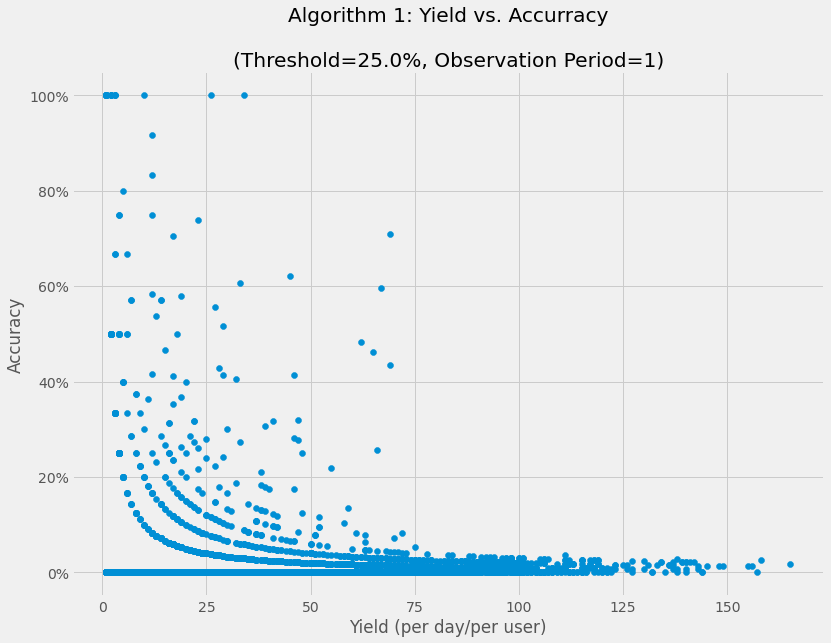

In [66]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
ax.scatter(x, y)
ax.set_xlabel('Yield (per day/per user)')
ax.set_ylabel('Accuracy')
ax.set_title(f'Algorithm 1: Yield vs. Accurracy\n\n(Threshold={threshold*100}%, Observation Period=1)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.savefig(f'alg1-threshold{int(threshold*100)}')